In [1]:
import pandas as pd
import numpy as np
import sklearn
import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq

In [2]:
train_group = pd.read_pickle('train_group.pickle')

In [3]:
train_group

event_type
user_id                          vacancy_id_            
000089d26cdd49d68839c68bc10f2cf2 177380                1
                                 181353                1
                                 195890                1
                                 205562                1
                                 211064                1
...                                                  ...
ffff62d297a347de801a1f824b4fef38 197408                1
                                 220736                1
                                 223476                1
                                 224509                1
                                 243259                1

[3287179 rows x 1 columns]

In [4]:
user_id=train_group.index.get_level_values(0)

In [5]:
vacancy_id_=train_group.index.get_level_values(1)

In [6]:
df = pd.DataFrame(list(zip( user_id, vacancy_id_, train_group['event_type'].to_list())), columns = ['user_id', 'vacancy_id_', 'rating'])

In [7]:
df

,user_id,vacancy_id_,rating
0,000089d26cdd49d68839c68bc10f2cf2,177380,1
1,000089d26cdd49d68839c68bc10f2cf2,181353,1
2,000089d26cdd49d68839c68bc10f2cf2,195890,1
3,000089d26cdd49d68839c68bc10f2cf2,205562,1
4,000089d26cdd49d68839c68bc10f2cf2,211064,1
...,...,...,...
3287174,ffff62d297a347de801a1f824b4fef38,197408,1
3287175,ffff62d297a347de801a1f824b4fef38,220736,1
3287176,ffff62d297a347de801a1f824b4fef38,223476,1
3287177,ffff62d297a347de801a1f824b4fef38,224509,1


**Prepare Data**

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
# all unique user_id
user_ids = df["user_id"].unique().tolist() 
num_all_user = len(user_ids)
print(num_all_user)

209335


In [10]:
# randomly select 90% users from dataset 
np.random.seed(123)
rand_userid = np.random.choice(user_ids, size = int(num_all_user * 0.9), replace=False)
sample_df = df.loc[df['user_id'].isin(rand_userid)]

In [11]:
sample_df

,user_id,vacancy_id_,rating
6,00008b2a006648b0b7eb409bbba203f1,108242,1
7,00008b2a006648b0b7eb409bbba203f1,110421,1
8,00008b2a006648b0b7eb409bbba203f1,113305,1
9,00008b2a006648b0b7eb409bbba203f1,120851,1
10,00008b2a006648b0b7eb409bbba203f1,123270,1
...,...,...,...
3287174,ffff62d297a347de801a1f824b4fef38,197408,1
3287175,ffff62d297a347de801a1f824b4fef38,220736,1
3287176,ffff62d297a347de801a1f824b4fef38,223476,1
3287177,ffff62d297a347de801a1f824b4fef38,224509,1


In [12]:
# userid, movieid encoding by indices
user_ids = sample_df['user_id'].unique()
num_users = len(user_ids)
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
sample_df['user_encoded'] = sample_df['user_id'].map(user2user_encoded)

C:\Users\Aliaksandr\AppData\Local\Temp\ipykernel_4748\2526383711.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['user_encoded'] = sample_df['user_id'].map(user2user_encoded)


In [13]:
vacancy_ids = sample_df['vacancy_id_'].unique()
num_vacancy = len(vacancy_ids)
vacancy2vacancy_encoded = {x: i for i, x in enumerate(vacancy_ids)}
vacancy_encoded2vacancy = {i: x for i, x in enumerate(vacancy_ids)}
sample_df['vacancy_encoded'] = sample_df['vacancy_id_'].map(vacancy2vacancy_encoded)

C:\Users\Aliaksandr\AppData\Local\Temp\ipykernel_4748\1523145239.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['vacancy_encoded'] = sample_df['vacancy_id_'].map(vacancy2vacancy_encoded)


In [14]:
# train-test split
train, test = train_test_split(sample_df, test_size = 0.2, random_state=123)

In [15]:
num_train_user = len(np.unique(train['user_encoded']))
num_train_vacancy = len(np.unique(train['vacancy_encoded']))

In [16]:
print(f'total vacancy: {num_vacancy}', 
      f'\nvacancy in train: {num_train_vacancy}', 
      f'\nvacancy not in train: {num_vacancy - num_train_vacancy} ({1 - num_train_vacancy / num_vacancy :.2f})', 
      f'\n\ntotal user: {num_users}', 
      f'\nuser in train: {num_train_user}', 
      f'\nuser not in train: {num_users - num_train_user} ({1 - num_train_user / num_users :.2f})'
     )

total vacancy: 153443 
vacancy in train: 148432 
vacancy not in train: 5011 (0.03) 

total user: 188401 
user in train: 187935 
user not in train: 466 (0.00)


**Embedding and Model**

In [17]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Concatenate, Dropout, Dense, BatchNormalization, concatenate, dot
from keras.optimizers import Adam
from keras.utils import plot_model, model_to_dot
from keras.constraints import non_neg
from IPython.display import SVG
from sklearn.metrics import mean_squared_error
import os

In [18]:
# input: an integer as embedding layer size, a float as drop out probability
# output: a keras NCF model with pre-constructed layers
def NCF_model(embed_size = 10, drop_out_prob = 0.2): 
    # define spaceholder of embedding inputs
    vacancy_input = Input(shape=[1],name='vacancy-input')
    user_input = Input(shape=[1], name='user-input')

    # MLP embeddings for both user and movie
    vacancy_embedding_mlp = Embedding(num_vacancy, embed_size, 
                                    name='vacancy-embedding-mlp')(vacancy_input)
    vacancy_vec_mlp = Flatten(name='flatten-vacancy-mlp')(vacancy_embedding_mlp)
    vacancy_vec_mlp = Flatten(name='flatten-vacancy-mlp')(vacancy_embedding_mlp)

    user_embedding_mlp = Embedding(num_users, embed_size, 
                                   name='user-embedding-mlp')(user_input)
    user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

    # MF embeddings for both user and movie
    vacancy_embedding_mf = Embedding(num_vacancy, embed_size, 
                                   name='vacancy-embedding-mf')(vacancy_input)
    vacancy_vec_mf = Flatten(name='flatten-vacancy-mf')(vacancy_embedding_mf)

    user_embedding_mf = Embedding(num_users, embed_size, 
                                  name='user-embedding-mf')(user_input)
    user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

    # MLP layers
    concat = concatenate([vacancy_vec_mlp, user_vec_mlp], axis=-1, name='concat')
    concat_dropout = Dropout(drop_out_prob)(concat)

    fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
    fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
    fc_1_dropout = Dropout(drop_out_prob)(fc_1_bn)

    fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
    fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
    fc_2_dropout = Dropout(drop_out_prob)(fc_2_bn)

    # Prediction from both layers
    pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
    pred_mf = dot([vacancy_vec_mf, user_vec_mf], axes=1, normalize=False)

    combine_mlp_mf = concatenate([pred_mf, pred_mlp], axis=-1, name='pred_mf')
    # Final prediction
    result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

    model = Model([user_input, vacancy_input], result)
    model.compile(optimizer=Adam(lr=0.01), loss='mean_squared_error')

    return model

In [35]:
model = NCF_model()


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vacancy-input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 vacancy-embedding-mlp (Embeddi  (None, 1, 10)       1534430     ['vacancy-input[0][0]']          
 ng)                                                                                              
                                                                                                  
 user-embedding-mlp (Embedding)  (None, 1, 10)       1884010     ['user-input[0][0]']         

In [37]:
train

,user_id,vacancy_id_,rating,user_encoded,vacancy_encoded
1501805,7511d6f0f42f4720b7f22b5f1e056558,242343,1,85938,132570
1896352,93c0b622cbef4bb89feca18c1555b872,153195,1,108406,4301
493420,263dfb634bec49489229728cbbf13427,204320,10,28283,64580
977598,4bba8627eb4e4425aa72ac4c31d9d1df,164728,1,55746,5188
1979799,9a553f28c22f46308fbcaf0b801c1f6b,215913,1,113259,202
...,...,...,...,...,...
2174757,a95251c2b17441d8a7362f072a2fbad6,101078,10,124363,36934
1382712,6b7837e7cd0d4b92921e4e7c735f1b9d,202608,1,79004,273
31693,02659582e3404650bd44dd55e05998e4,188238,1,1783,17330
309831,180536d80a744523ab7cc74795282dc8,218938,1,17687,44547


Epoch 1/5


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


73966/73966 [==============================] - 7088s 96ms/step - loss: 10.1093
Epoch 2/5
73966/73966 [==============================] - 6866s 93ms/step - loss: 8.8946
Epoch 3/5
73966/73966 [==============================] - 6854s 93ms/step - loss: 8.5332
Epoch 4/5
73966/73966 [==============================] - 6852s 93ms/step - loss: 8.3220
Epoch 5/5
73966/73966 [==============================] - 6881s 93ms/step - loss: 8.1465


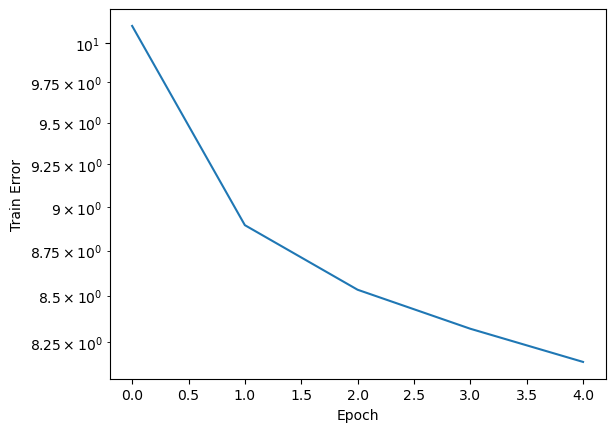

In [77]:
# train NCF model on training data, embedding size 20, dropout rate as default
model = NCF_model(embed_size=20)
history = model.fit([train['user_encoded'], train['vacancy_encoded']], train['rating'], epochs=5)

pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

In [78]:
# uncomment to save model as 'dl_model.h5'
model.save('dl_model.h5')

In [19]:
# uncomment to load model
from keras.models import load_model
model = load_model('dl_model.h5')

In [20]:
test['user_encoded']

2842141    162695
649173      37180
2326862    133292
884674      50386
1702253     97346
            ...  
1954519    111869
214932      12193
2936784    168118
1303754     74559
2195047    125581
Name: user_encoded, Length: 591725, dtype: int64

In [21]:
# rmse on testing set 
y_hat = np.round(model.predict([test['user_encoded'], test['vacancy_encoded']]), decimals=2)
y_true = test['rating']
print(f'testing rms: {mean_squared_error(y_true, y_hat)}')

18492/18492 [==============================] - 23s 1ms/step
testing rms: 9.471599612450891


In [22]:
# prediction sample
d = {'prediction': y_hat.tolist(), 'true_value': y_true.values.tolist()}
test_pred = pd.DataFrame(d)
test_pred.head(5)

,prediction,true_value
0,[7.099999904632568],10
1,[1.2699999809265137],1
2,[1.5800000429153442],1
3,[1.3600000143051147],1
4,[8.140000343322754],1


In [23]:
test_pred.head(30)

,prediction,true_value
0,[7.099999904632568],10
1,[1.2699999809265137],1
2,[1.5800000429153442],1
3,[1.3600000143051147],1
4,[8.140000343322754],1
5,[1.809999942779541],1
6,[1.6100000143051147],10
7,[1.4900000095367432],1
8,[5.900000095367432],1
9,[4.619999885559082],1


In [81]:
from sklearn.model_selection import KFold

# sample 100k from training set as validation set 
valid_df_size = 100000
valid_df = train.sample(n = int(valid_df_size), replace=False, random_state=123)

embedding_layers = [5, 10, 15, 20, 25, 30]

In [82]:
# input: validation data set, list of embedding layer size, drop-out probability, number of epochs, number of fold
# output: list of cv-rmse for each hyperparameter value
def NCF_cross_validation(cv_df, eb_layers, drop_prob = 0.2, epoch=3, n_split=3):
    cv_result = []

    for el in eb_layers:      
        temp_loss = []
        itr_idx = 0
        
        for train_idx, test_idx in KFold(n_split).split(cv_df):          
            cv_train_x = cv_df.iloc[train_idx][['user_encoded', 'vacancy_encoded']]
            cv_test_x = cv_df.iloc[test_idx][['user_encoded', 'vacancy_encoded']]
            cv_train_y = cv_df.iloc[train_idx]['rating']
            cv_test_y = cv_df.iloc[test_idx]['rating']

            model_cv = NCF_model()
            model_cv.fit([cv_train_x['user_encoded'], cv_train_x['vacancy_encoded']], cv_train_y, epochs=epoch)

            curr_loss = model_cv.evaluate([cv_df['vacancy_encoded'], cv_df['vacancy_encoded']], cv_df['rating'])
            temp_loss.append(curr_loss)         
            itr_idx += 1
            
        cv_result.append(sum(temp_loss) / n_split)
            
    return cv_result

In [83]:
cv_result = NCF_cross_validation(valid_df, embedding_layers)

Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 102s 48ms/step - loss: 11.9247
Epoch 2/3
2084/2084 [==============================] - 104s 50ms/step - loss: 8.2317
Epoch 3/3
3125/3125 [==============================] - 5s 1ms/step - loss: 10.8280
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 112s 53ms/step - loss: 11.9268
Epoch 2/3
2084/2084 [==============================] - 108s 52ms/step - loss: 7.9735
Epoch 3/3
3125/3125 [==============================] - 5s 2ms/step - loss: 11.1712
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 103s 49ms/step - loss: 11.8507
Epoch 2/3
2084/2084 [==============================] - 100s 48ms/step - loss: 8.1718
Epoch 3/3
3125/3125 [==============================] - 4s 1ms/step - loss: 11.3619
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 102s 48ms/step - loss: 11.8652
Epoch 2/3
2084/2084 [==============================] - 108s 52ms/step - loss: 7.9178
Epoch 3/3
3125/3125 [==============================] - 5s 1ms/step - loss: 11.6567
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 98s 46ms/step - loss: 11.9174
Epoch 2/3
2084/2084 [==============================] - 99s 47ms/step - loss: 5.8551
Epoch 3/3
3125/3125 [==============================] - 5s 1ms/step - loss: 11.3562
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 103s 49ms/step - loss: 11.8774
Epoch 2/3
2084/2084 [==============================] - 103s 49ms/step - loss: 6.5940
Epoch 3/3
3125/3125 [==============================] - 4s 1ms/step - loss: 11.0519
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 100s 47ms/step - loss: 11.9183
Epoch 2/3
2084/2084 [==============================] - 100s 48ms/step - loss: 5.9535
Epoch 3/3
3125/3125 [==============================] - 4s 1ms/step - loss: 11.0329
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 100s 47ms/step - loss: 12.0147
Epoch 2/3
2084/2084 [==============================] - 100s 48ms/step - loss: 7.1017
Epoch 3/3
3125/3125 [==============================] - 4s 1ms/step - loss: 10.9426
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 99s 47ms/step - loss: 11.9125
Epoch 2/3
2084/2084 [==============================] - 99s 47ms/step - loss: 9.3481
Epoch 3/3
3125/3125 [==============================] - 4s 1ms/step - loss: 11.2451
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 100s 47ms/step - loss: 11.9213
Epoch 2/3
2084/2084 [==============================] - 99s 47ms/step - loss: 9.3508
Epoch 3/3
3125/3125 [==============================] - 4s 1ms/step - loss: 11.4749
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 99s 47ms/step - loss: 11.9398
Epoch 2/3
2084/2084 [==============================] - 98s 47ms/step - loss: 9.1733
Epoch 3/3
3125/3125 [==============================] - 4s 1ms/step - loss: 11.3365
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 100s 47ms/step - loss: 11.8711
Epoch 2/3
2084/2084 [==============================] - 100s 48ms/step - loss: 7.5818
Epoch 3/3
3125/3125 [==============================] - 5s 1ms/step - loss: 11.4048
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 99s 47ms/step - loss: 11.8942
Epoch 2/3
2084/2084 [==============================] - 99s 47ms/step - loss: 6.5410
Epoch 3/3
3125/3125 [==============================] - 5s 1ms/step - loss: 11.1455
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 99s 47ms/step - loss: 11.9170
Epoch 2/3
2084/2084 [==============================] - 109s 52ms/step - loss: 5.5110
Epoch 3/3
3125/3125 [==============================] - 5s 2ms/step - loss: 11.1060
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 103s 49ms/step - loss: 11.8463
Epoch 2/3
2084/2084 [==============================] - 123s 59ms/step - loss: 8.1939
Epoch 3/3
3125/3125 [==============================] - 7s 2ms/step - loss: 11.2322
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 120s 57ms/step - loss: 11.9070
Epoch 2/3
2084/2084 [==============================] - 119s 57ms/step - loss: 8.8396
Epoch 3/3
3125/3125 [==============================] - 4s 1ms/step - loss: 11.3026
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 104s 49ms/step - loss: 11.8764
Epoch 2/3
2084/2084 [==============================] - 106s 51ms/step - loss: 7.4445
Epoch 3/3
3125/3125 [==============================] - 4s 1ms/step - loss: 10.9535
Epoch 1/3


C:\Users\Aliaksandr\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2084/2084 [==============================] - 131s 62ms/step - loss: 11.8939
Epoch 2/3
2084/2084 [==============================] - 124s 60ms/step - loss: 8.3241
Epoch 3/3
3125/3125 [==============================] - 5s 2ms/step - loss: 11.6432


[Text(0.5, 0, 'Embedding Dim'),
 Text(0, 0.5, 'CV rmse'),
 Text(0.5, 1.0, '3-Fold CV')]

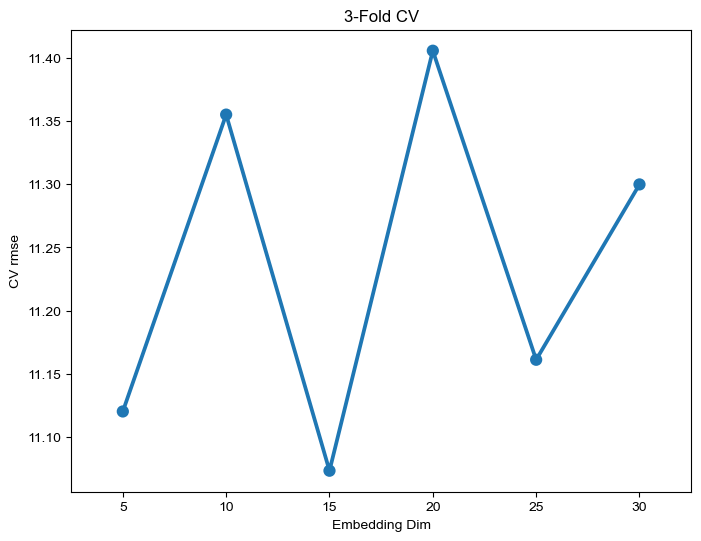

In [84]:
cv_result_df = pd.DataFrame({'cv_rmse': cv_result}, index = embedding_layers)

fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('whitegrid')
sns.pointplot(x=cv_result_df.index, y=cv_result_df.cv_rmse, ax=ax)
ax.set(xlabel='Embedding Dim', ylabel='CV rmse', title='3-Fold CV')

**Top 20 recommendations**

In [24]:
# input: a recommendation model (keras model), user id, number of recommendation
# output: a dataframe of top-k recommendations along with movie information
def NCF_recommendation(rec_model, client_id, top_k = 20):
    client_encoded = user2user_encoded[client_id]
    vacancy_watched = sample_df[sample_df['user_id'] == client_id]['vacancy_id_'].values
    
    vacancy_poll_encoded = []
    for item in vacancy_ids:
        if not np.isin(item, vacancy_watched):
            vacancy_poll_encoded.append(vacancy2vacancy_encoded[item])
            
    d = {'user_encoded': [client_encoded] * len(vacancy_poll_encoded), 'vacancy_encoded' : vacancy_poll_encoded}
    client_df = pd.DataFrame(d)
    
    ratings = rec_model.predict([client_df['user_encoded'], client_df['vacancy_encoded']])
    
    top_ratings_idx = ratings.flatten().argsort()[-top_k:][::-1]
    top_ratings = ratings[top_ratings_idx].flatten()
    recommend_vacancy = [vacancy_encoded2vacancy.get(vacancy_poll_encoded[x]) for x in top_ratings_idx]
    
    top_vacancy_rec = pd.DataFrame({'vacancy_id_': recommend_vacancy, 'prediction': top_ratings}).set_index('vacancy_id_')
    

    return top_vacancy_rec 

In [25]:
user_ids

array(['00008b2a006648b0b7eb409bbba203f1',
       '000092a5cbb044fb9857e794305ab40b',
       '0000cbf5d577428aaf1765ba454c9d65', ...,
       'ffff1bf72ede43b483945d2af54c79f2',
       'ffff5d9f57a149999ef2bf1e10683c91',
       'ffff62d297a347de801a1f824b4fef38'], dtype=object)

In [26]:
test_12345=test.groupby(['user_encoded', 'vacancy_encoded']).agg({'rating':'max'})

In [29]:
test_12345

rating
user_encoded vacancy_encoded        
2            18                    1
             30                    1
             32                    1
             34                    1
             36                    1
...                              ...
188399       6067                  1
188400       18052                 1
             19441                 1
             46759                 1
             96044                 1

[591725 rows x 1 columns]

In [30]:
test_user_ids = test["user_id"].unique().tolist() 

In [43]:
test[(test.user_id==test_user_ids[4]) & (test.rating==10)]

,user_id,vacancy_id_,rating,user_encoded,vacancy_encoded
1702262,84c24e67736849a6b9b99a81fbd179ca,249229,10,97346,6166
1702244,84c24e67736849a6b9b99a81fbd179ca,101424,10,97346,68030


In [45]:
client_id=test_user_ids[6]

In [46]:
#client_id = int(np.random.choice(user_ids, 1))
print(f'recommendation for client: {client_id}')
NCF_recommendation(model, client_id, top_k=20)

recommendation for client: 13d9bf32338647559067c734adc0ef80
4792/4792 [==============================] - 6s 1ms/step


,prediction
vacancy_id_,
207098,12.565970
199721,11.670722
155858,11.620881
217648,11.589323
135728,11.521319
180640,11.514744
244550,11.443780
235097,11.382203
258826,11.381625


In [146]:
client_id='00008b2a006648b0b7eb409bbba203f1'

In [166]:
test_public_mfti = pq.read_table('test_public_mfti.parquet').to_pandas()

In [169]:
train = pq.read_table('train_mfti.parquet').to_pandas()

train=train[['cookie_id', 'user_id']]

train = train.loc[train['cookie_id'].isin(list(test_public_mfti.cookie_id.unique()))]

train=train.drop_duplicates()

In [206]:
list_list=[]
for i in test_public_mfti.cookie_id:
    try:
        client_id=train.user_id[train.cookie_id==i].to_list()[0]
        if client_id in [None]:
            list_list.append(None)
        else:
            list_list.append(NCF_recommendation(model, client_id, top_k=15).index)
    except:
        list_list.append('error')
        
    
    

4795/4795 [==============================] - 6s 1ms/step


4795/4795 [==============================] - 6s 1ms/step


In [207]:
 list_list

['error',
 Int64Index([207098, 122785, 244550, 217648, 180640, 135728, 130892, 155858,
             156394, 235097, 187462, 213454, 190006, 146114, 258826],
            dtype='int64', name='vacancy_id_'),
 Int64Index([207098, 199721, 155858, 258826, 217648, 135728, 229735, 244261,
             115133, 235097, 244550, 180640, 157328, 181459, 213454],
            dtype='int64', name='vacancy_id_'),
 Int64Index([207098, 244550, 155858, 180640, 122785, 135728, 217648, 199721,
             235097, 130892, 258826, 213454, 181459, 229735, 156394],
            dtype='int64', name='vacancy_id_'),
 Int64Index([207098, 155858, 217648, 135728, 199721, 180640, 258826, 235097,
             244550, 213454, 229735, 181459, 157328, 244261, 150392],
            dtype='int64', name='vacancy_id_'),
 'error',
 Int64Index([207098, 115133, 199721, 155858, 244261, 258826, 236581, 163866,
             237377, 229735, 129783, 251385, 104266, 173632, 190867],
            dtype='int64', name='vacancy_id_'),
 None

In [208]:
test_public_mfti['predict']= list_list

In [209]:
test_public_mfti

,cookie_id,vacancy_id_,predict
0,000cd76cd33f43d4a1ac1d16d10f8bf7,"[222177, 222173, 222163, 238874, 238878, 22812...",error
1,0034bc7f404341ba8412665453e7825a,"[102794, 137587, 257319, 237756, 240744, 11348...","Int64Index([207098, 122785, 244550, 217648, 18..."
2,00a6c5a64a274c55a836402bdeb3b2c4,"[254292, 164602, 116438, 228634, 218819, 24065...","Int64Index([207098, 199721, 155858, 258826, 21..."
3,015937a125b14e74bdff1cddc49f9172,"[246685, 138123, 115420, 210628, 212325, 235196]","Int64Index([207098, 244550, 155858, 180640, 12..."
4,01de50c280794cec8804f16f45f847b7,"[219070, 251469, 166899, 212703, 214561]","Int64Index([207098, 155858, 217648, 135728, 19..."
...,...,...,...
767,fdbcda17f22f406486837059e76c7fed,"[207851, 254989, 213344, 214180, 222146]","Int64Index([207098, 155858, 199721, 217648, 13..."
768,fe6193ab26494ace9be5aae36e507618,"[115352, 230546, 225527, 120188, 109360, 23212...",error
769,fe95b2826ee1452b81201ed3f4c3294d,"[240362, 114852, 253946, 251081, 127546, 244688]",None
770,ff1aef256a49481698bb2e938510ff36,"[231194, 236363, 220747, 244688, 100094, 24052...","Int64Index([207098, 199721, 155858, 258826, 21..."


In [229]:
test_public_mfti.loc[0, :].predict

'error'

In [256]:
len(set(test_public_mfti.loc[4, :].predict[:15])&set(test_public_mfti.loc[4, :]['vacancy_id_']))

0

In [221]:
set(test_public_mfti.loc[1, :]['vacancy_id_'])


{102794,
 109269,
 113482,
 137587,
 191512,
 205578,
 221376,
 222762,
 231446,
 235561,
 237756,
 240245,
 240744,
 242642,
 257319}

In [ ]:
append(len(a & b)/5)

In [281]:
list_5=[]
list_10=[]
list_15=[]
list_error=[]
for i in range(len(test_public_mfti)):
    try:
        if len(test_public_mfti.loc[i, :].predict)<15:
            list_error.append([test_public_mfti.loc[i, :].predict])
        else:
            list_5.append(len(set(test_public_mfti.loc[i, :].predict[:5])&set(test_public_mfti.loc[i, :]['vacancy_id_'])))
            list_10.append(len(set(test_public_mfti.loc[i, :].predict[:10])&set(test_public_mfti.loc[i, :]['vacancy_id_'])))
            list_15.append(len(set(test_public_mfti.loc[i, :].predict[:15])&set(test_public_mfti.loc[i, :]['vacancy_id_'])))
    except:
        print(i, test_public_mfti.loc[i, :].predict)


7 None
14 None
16 None
17 None
19 None
36 None
37 None
39 None
48 None
50 None
55 None
69 None
70 None
78 None
80 None
83 None
103 None
106 None
110 None
125 None
128 None
130 None
136 None
138 None
142 None
150 None
158 None
162 None
170 None
177 None
178 None
186 None
194 None
196 None
203 None
212 None
219 None
222 None
224 None
225 None
227 None
233 None
237 None
239 None
245 None
250 None
252 None
253 None
254 None
257 None
260 None
264 None
265 None
266 None
267 None
269 None
270 None
271 None
274 None
279 None
282 None
285 None
286 None
289 None
290 None
301 None
304 None
306 None
309 None
310 None
312 None
316 None
322 None
325 None
339 None
344 None
346 None
348 None
349 None
352 None
356 None
361 None
362 None
365 None
366 None
367 None
368 None
375 None
376 None
377 None
378 None
380 None
382 None
391 None
397 None
399 None
400 None
404 None
408 None
409 None
421 None
427 None
429 None
431 None
432 None
437 None
440 None
443 None
445 None
446 None
449 None
450 None
457 None


In [282]:
list_15

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
